# <a id='toc1_'></a>[Descripcipción del proyecto](#toc0_)

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

**Table of contents**<a id='toc0_'></a>    
- [Descripcipción del proyecto](#toc1_)    
  - [Inicialización](#toc1_1_)    
  - [Cargar datos](#toc1_2_)    
  - [EDA](#toc1_3_)    
  - [Procedimiento de evaluación](#toc1_4_)    
  - [Normalización](#toc1_5_)    
  - [División entrenamiento / prueba](#toc1_6_)    
  - [Trabajar con modelos](#toc1_7_)    
    - [Preprocesamiento para modelos](#toc1_7_1_)    
    - [Modelo 0 - Constante](#toc1_7_2_)    
    - [Modelo 1 - TF-IDF y LR](#toc1_7_3_)    
    - [Modelo 2 - NLTK, TF-IDF y LR](#toc1_7_4_)    
    - [Modelo 3 - spaCy, TF-IDF y LR](#toc1_7_5_)    
    - [Modelo 4 - TF-IDF y LGBMClassifier](#toc1_7_6_)    
    - [Modelo 5 - NLTK, TF-IDF y LGBMClassifier](#toc1_7_7_)    
    - [Modelo 6 - spaCy, TF-IDF y LGBMClassifier](#toc1_7_8_)    
  - [Mis reseñas](#toc1_8_)    
    - [Modelo 1](#toc1_8_1_)    
    - [Modelo 2](#toc1_8_2_)    
    - [Modelo 3](#toc1_8_3_)    
    - [Modelo 4](#toc1_8_4_)    
    - [Modelo 5](#toc1_8_5_)    
    - [Modelo 6](#toc1_8_6_)    
  - [Conclusiones](#toc1_9_)    
- [Lista de comprobación](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Inicialización](#toc0_)

In [68]:
import math

import re
import numpy as np 
import pandas as pd
import spacy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

## <a id='toc1_2_'></a>[Cargar datos](#toc0_)

In [5]:
df_reviews = pd.read_csv('../../data/raw/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.info()
df_reviews.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283


Tras una rápida investigación encontramos que IMDb explica que representa cada columna. Éstas son:
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes  – primary runtime of the title, in minutes
- isAdult (boolean) - 0: non-adult title; 1: adult title
- genres (string array) – includes up to three genres associated with the title
- averageRating – weighted average of all the individual user ratings
- Votes – number of votes the title has received
- review – el texto de la reseña
- rating – nota de la reseña
- sp – el objetivo en formato string
- pos – el objetivo, '0' para negativo y '1' para positivo
- ds_part – 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente
- idx – supongo que es la id del usuario que escribió la reseña ya que no dice en la página
  
Puede que haya una mezcla de idiomas en la lista, pero no me iba a poner a traducir todo el texto. Pero al menos tenemos aclarado que quiere decir cada columna y sabremos cuales nos serán útiles para nuestro modelo. A primera vista no parece que nos vayan a importar mucho varias columnas ya que queremos predecir la postura del texto, no si una película en particular va a tener buenas reseñas o no.
  
Vamos a pasar al EDA para refinar bien las ideas sobre los datos!

## <a id='toc1_3_'></a>[EDA](#toc0_)

In [7]:
# Comprobamos no tener duplicados
df_reviews.duplicated().sum()

0

Veamos el número de películas y reseñas a lo largo de los años.

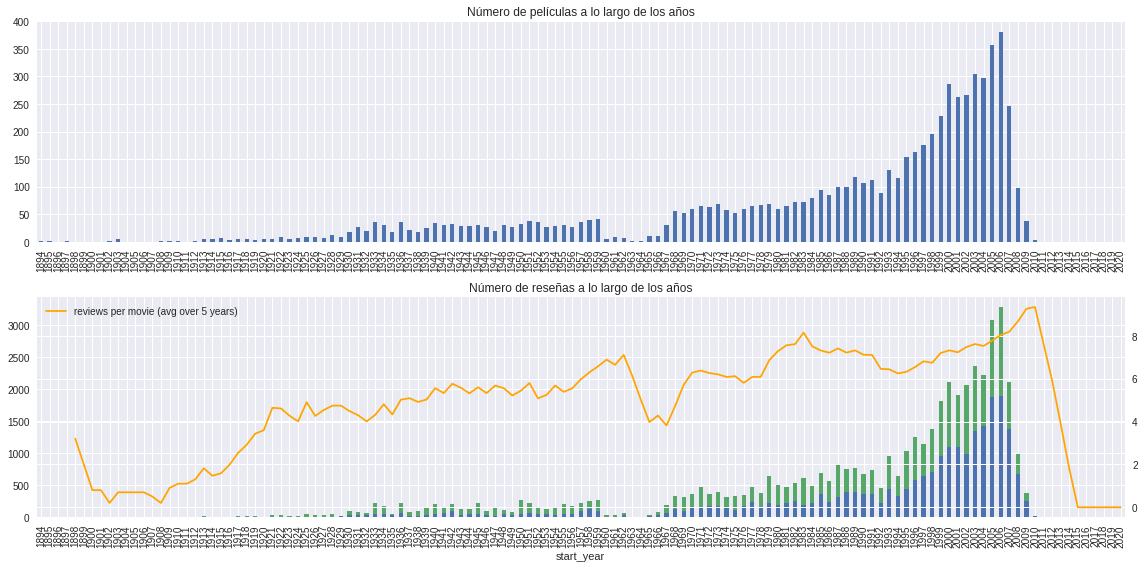

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Como era de esperar, al principio las películas eran mucho menos comunes y poco a poco fueron volviendose más populares. Notamos un hueco en la década del 60 pero puede haberse dado debido a la guerra fría, posteriormente se ve un crecimiento a un muy buen ritmo seguido de una explosión mucho más grande posterior al año 2000.
  
Por su parte, las reseñas parecen haber tenido una cantidad mayor y con más cambios a lo largo del tiempo. De todas formas si fueron siguiendo a la cantidad de películas publicadas, ésto se hace evidente en la época de los 60.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

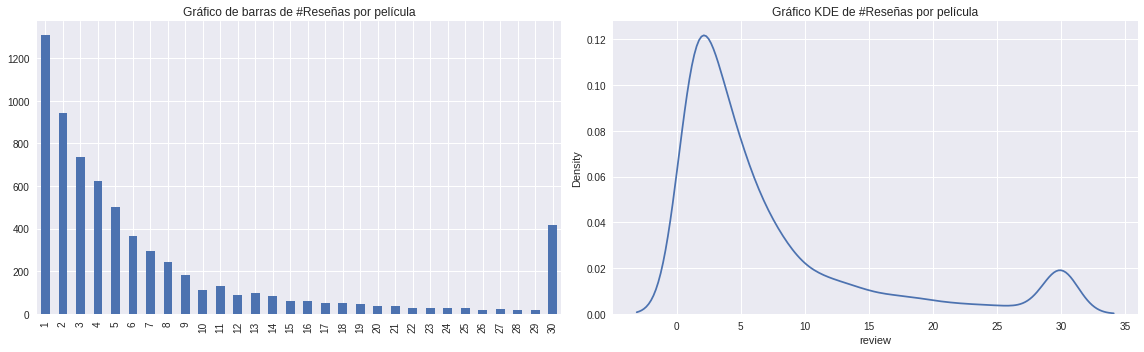

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Al parecer lo normal dentro de los datos es que las películas tengan o muy pocas reseñas o... 30? Es un número muy específico pero se me ocurren varias teorías de como llegan así los datos (por ejemplo, que IMBd entregue una cantidad aleatoria de reseñas pero controladas respecto a la cantidad de reseñas por película).

In [10]:
# Observemos como se distribuye nuestro objetivo en el conjunto de entrenamiento
pd.concat([
df_reviews[df_reviews['ds_part'] == "train"]['pos'].value_counts(),
df_reviews[df_reviews['ds_part'] == "train"]['pos'].value_counts(normalize=True)
], axis=1)

,pos,pos
0,11912,0.500588
1,11884,0.499412


In [11]:
# Difiere mucho del conjunto de prueba?
pd.concat([
df_reviews[df_reviews['ds_part'] == "test"]['pos'].value_counts(),
df_reviews[df_reviews['ds_part'] == "test"]['pos'].value_counts(normalize=True)
], axis=1)

,pos,pos
0,11803,0.501508
1,11732,0.498492


Al parecer no vemos una gran cantidad de desbalance en nuestros datos, eso es una ventaja ya que no tendremos que aplicar métodos para encargarnos de ello. Y tampoco vemos una diferencia notable entre el conjunto de entrenamiento y el de prueba.
  
Con ese gran detalle fuera de lugar veamos como se distribuyen las notas de éste querido DataFrame!

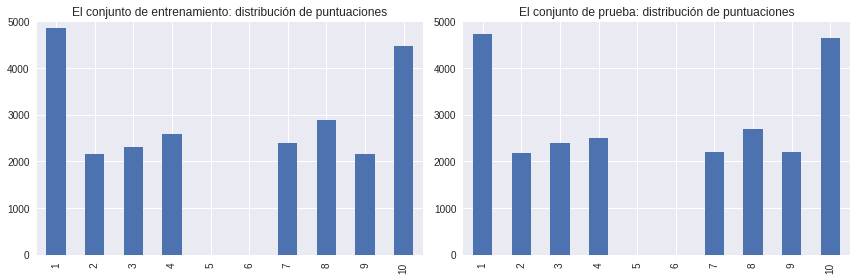

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Supongo que cuando dicen que en internet es difícil encontrar grises se deben referir a cosas como ésto. Me parece de más extraño no encontrar ninguna reseña intermedia con 47331 diferentes escritos, aunque con las dimensiones de gráfico no me sorprendería que incluso 50 reseñas no sean visibles en absoluto.

In [13]:
# De todas formas verifiquemos bien si realmente no hay reseñas o si es una ilusión
len(df_reviews[(df_reviews['rating'] > 4) & (df_reviews['rating'] < 7)])

0

Efectivamente no tenemos ninguna reseña intermedia en nuestras 47331 filas! Eso... no es completamente una desventaja ya que nos evitar obtener dichos textos que no poseen una postura positiva o negativa tan marcada y que podrían confundir a nuestros modelos.

Ahora veamos la distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

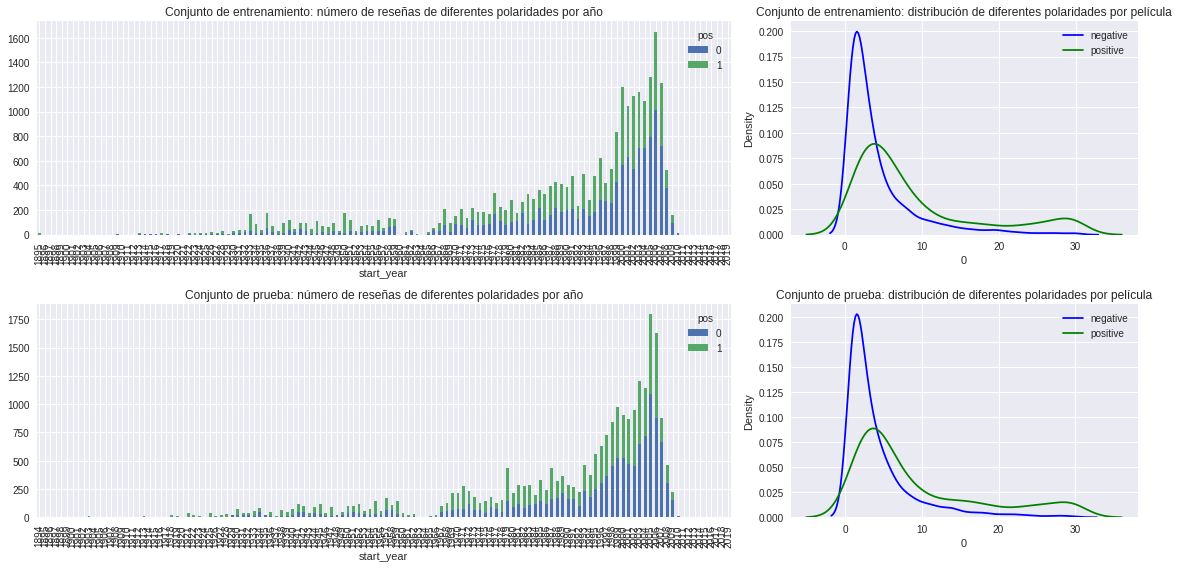

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Por más que nuestro target esté balanceado nos damos cuenta de que a los años no siempre fue así ya que podemos ver barras (representando años específicos) que tienen una clara presencia de uno de los dos colores y no del otro. Por su parte el KDE nos muestra otro dato interesante ya que podemos ver que si una película tiene muchas reseñas lo más probable es que sean mayormente positivas mientras que si tiene pocas es más probable que sean negativas (aunque si hay margen para que sea positiva).
  
Mientras tanto nos podemos quedar tranquilo ya que las gráficas de *train* y *test* no parecen ser demasiado diferente, lo que nos dará un buen juicio de la efectividad de nuestros modelos.
  
Ahora pasemos a analizar las reseñas en cuestión y como se reflejan en nuestro target.

In [15]:
# Separemos en una nueva variable para trabajar más libremente
eda_df = df_reviews.copy()

# Y guardemos el mapping de train y test
train_map = df_reviews['ds_part'] == "train"
test_map = df_reviews['ds_part'] == "test"

In [16]:
eda_df['length'] = eda_df['review'].str.len()

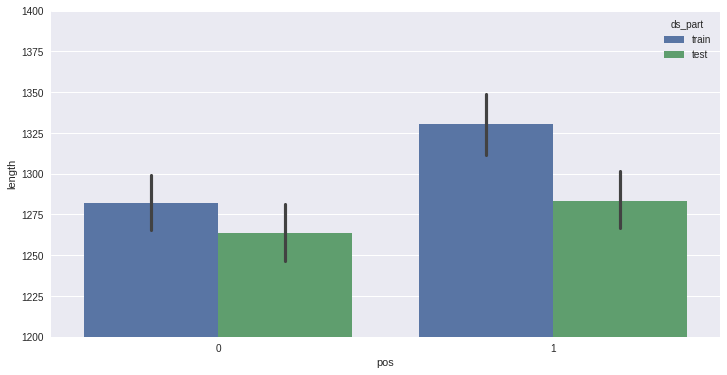

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=eda_df, x="pos", y="length", hue='ds_part')
plt.ylim(1200, 1400)
plt.show()

Al parecer las reseñas que tenemos acá son todas muy expresivas más allá de si les gustó la película o no, dejando reseñas más largas si les gustó. Habría que realizar ésta gráfica despues de eliminar las stop words y lematizar los textos para ver que tanto cambia la situación.
  
Y para nuestra tranquilidad vemos una vez más las similaridades entre train y test. Solo vemos una pequeña diferencia en las reseñas positivas mientras que en las negativas las barras de error nos permiten decir que son muy similares.

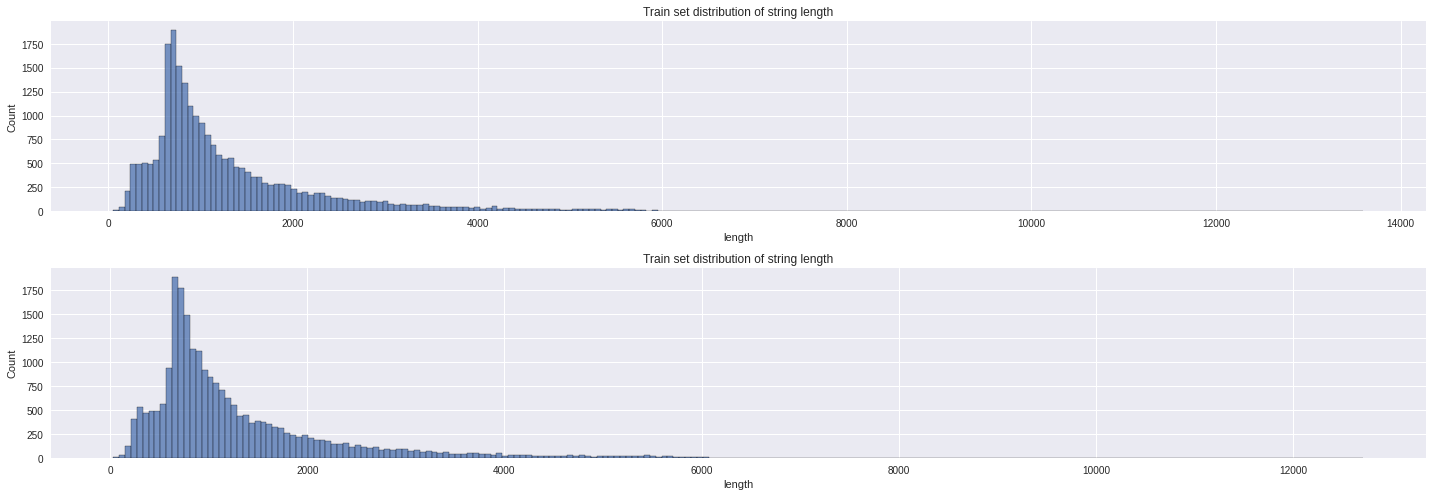

In [18]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 7))

sns.histplot(data=eda_df[train_map], x="length", ax=ax[0])
ax[0].set_title("Train set distribution of string length")

sns.histplot(data=eda_df[test_map], x="length", ax=ax[1])
ax[1].set_title("Train set distribution of string length")

fig.tight_layout()

Como podemos observar la mayoría de las reseñas tienen menos de 2000 caracteres pero algunas llegan hasta más de 12000! Al parecer no todas las personas tienen lo mismo para decir. Veamos separando por si la reseña es positiva o negativa.

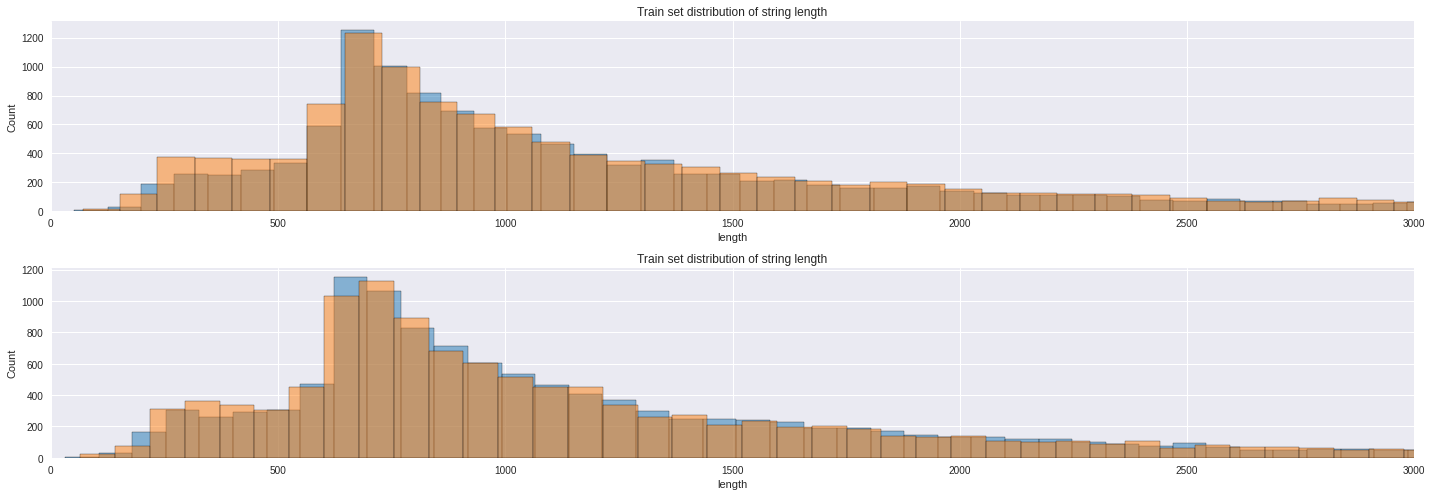

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 7))

sns.histplot(data=eda_df[(train_map) & (eda_df['pos'] == 0)], x="length", ax=ax[0], alpha=0.5, color='tab:blue')
sns.histplot(data=eda_df[(train_map) & (eda_df['pos'] == 1)], x="length", ax=ax[0], alpha=0.5, color='tab:orange')
ax[0].set_title("Train set distribution of string length")
ax[0].set_xlim(0,3000)

sns.histplot(data=eda_df[(test_map) & (eda_df['pos'] == 0)], x="length", ax=ax[1], alpha=0.5, color='tab:blue')
sns.histplot(data=eda_df[(test_map) & (eda_df['pos'] == 1)], x="length", ax=ax[1], alpha=0.5, color='tab:orange')
ax[1].set_title("Train set distribution of string length")
ax[1].set_xlim(0,3000)

fig.tight_layout()

Decidí "hacer zoom" para ver si así podíamos ver mejor las diferencias entre las reseñas positivas y las negativas, pero al parecer dichas diferencias no son muy grandes aunque en el conjunto de train parece haber una mayor cantidad de reseñas positivas en los valores que podemos. Por lo tanto ya que tenemos una cantidad balanceada de positivas y negativas es evidente que si nos vamos hacia valores más altos nos encontraremos que los negativos tendran una mayor presencia a las reseñas positivas. Y si lo pensamos, tiene sentido ya que alguien disatisfecho es más propenso a descargarse y escribir más.

## <a id='toc1_4_'></a>[Procedimiento de evaluación](#toc0_)

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [51]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    return df_eval_stats

## <a id='toc1_5_'></a>[Normalización](#toc0_)

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [21]:
def clear_text(text):
    
    # Primero definimos la regex y reemplazamos los carácteres especiales por espacios
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, ' ', text)
    
    # Ahora desarmamos y rearmamos los textos para eliminar los espacios de sobra
    text = text.split()
    text = ' '.join(text)
    
    # Finalmente convertimos todo a minúsculas
    text = text.lower()
    
    return text

In [23]:
# Finalmente creamos la nueva columna con las reviews limpias
df_reviews['review_norm'] = pd.Series(df_reviews['review'].apply(clear_text))

In [24]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
# Hacemos una funcion para lematizar el texto con spaCy
def spacy_lemmatize(text):

    doc = nlp(text)

    lemmas = []
    
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [26]:
nltk = WordNetLemmatizer()

In [27]:
# Hacemos una funcion para lematizar el texto con NLTK
def nltk_lemmatize(text):

    tokens = word_tokenize(text)

    lemmas = []
    lemmatizer = WordNetLemmatizer()
    
    for token in tokens:
        lemmas.append(lemmatizer.lemmatize(token))
        
    return ' '.join(lemmas)

In [131]:
%%time
# Creamos una columna con las reseñas lematizadas con nltk
df_reviews['nltk_lemmatized_review'] = df_reviews['review_norm'].apply(nltk_lemmatize)

CPU times: user 1min 53s, sys: 34.7 ms, total: 1min 54s
Wall time: 1min 54s


In [34]:
# Y una con las reseñas lematizadas con spaCy
df_reviews['spacy_lemmatized_review'] = df_reviews['review_norm'].apply(spacy_lemmatize)

CPU times: user 16min 54s, sys: 8.27 s, total: 17min 2s
Wall time: 17min 4s


## <a id='toc1_6_'></a>[División entrenamiento / prueba](#toc0_)

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [35]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 20)
(23535, 20)


## <a id='toc1_7_'></a>[Trabajar con modelos](#toc0_)

### <a id='toc1_7_1_'></a>[Preprocesamiento para modelos](#toc0_)
  
Ahora vamos a trabajar con nuestra tabla para dejar los datos en formatos que nuestros modelos puedan entender.

In [119]:
# Primero cargamos los corpus sin lematizar
train_corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']

# Y vectorizamos a TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words="english", lowercase=True)
train_tf_idf = tfidf_vectorizer.fit_transform(train_corpus)
test_tf_idf = tfidf_vectorizer.transform(test_corpus)

In [120]:
# Y una vez más lo hacemos para NLTK
nltk_train_corpus = df_reviews_train['nltk_lemmatized_review']
nltk_test_corpus = df_reviews_test['nltk_lemmatized_review']

tfidf_vectorizer_nltk = TfidfVectorizer(stop_words="english", lowercase=True)
nltk_train_tf_idf = tfidf_vectorizer_nltk.fit_transform(nltk_train_corpus)
nltk_test_tf_idf = tfidf_vectorizer_nltk.transform(nltk_test_corpus)

In [121]:
# Repetimos el proceso para las reseñas lematizadas de spaCy
spacy_train_corpus = df_reviews_train['spacy_lemmatized_review']
spacy_test_corpus = df_reviews_test['spacy_lemmatized_review']

# Cargamos un nuevo vectorizador
tfidf_vectorizer_spacy = TfidfVectorizer(stop_words="english", lowercase=True)
spacy_train_tf_idf = tfidf_vectorizer_spacy.fit_transform(spacy_train_corpus)
spacy_test_tf_idf = tfidf_vectorizer_spacy.transform(spacy_test_corpus)

### <a id='toc1_7_2_'></a>[Modelo 0 - Constante](#toc0_)

In [39]:
from sklearn.dummy import DummyClassifier

In [ ]:
# evaluate_model(model, train_features, train_target, test_features, test_target)

In [45]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(train_tf_idf, train_target)

DummyClassifier(strategy='uniform')

,train,test
Exactitud,0.5,0.51
F1,0.5,0.50
APS,0.5,0.50
ROC AUC,0.5,0.50


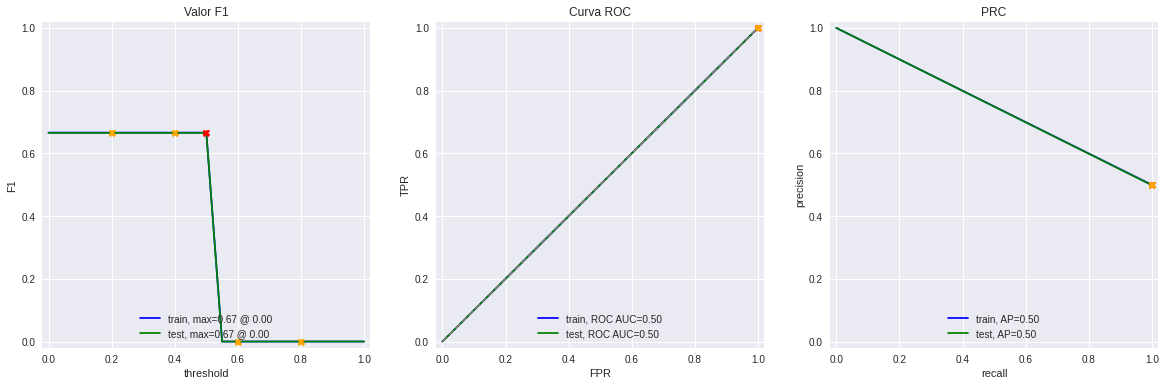

In [52]:
dummy_evaluation = evaluate_model(dummy_model, train_tf_idf, train_target, test_tf_idf, test_target)
dummy_evaluation

### <a id='toc1_7_3_'></a>[Modelo 1 - TF-IDF y LR](#toc0_)

In [ ]:
# evaluate_model(model, train_features, train_target, test_features, test_target)

In [61]:
%%time
model_1 = LogisticRegression()
model_1.fit(train_tf_idf, train_target)

CPU times: user 2 s, sys: 3.74 s, total: 5.75 s
Wall time: 5.67 s


LogisticRegression()

CPU times: user 554 ms, sys: 28.1 ms, total: 582 ms
Wall time: 633 ms


,train,test
Exactitud,0.94,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


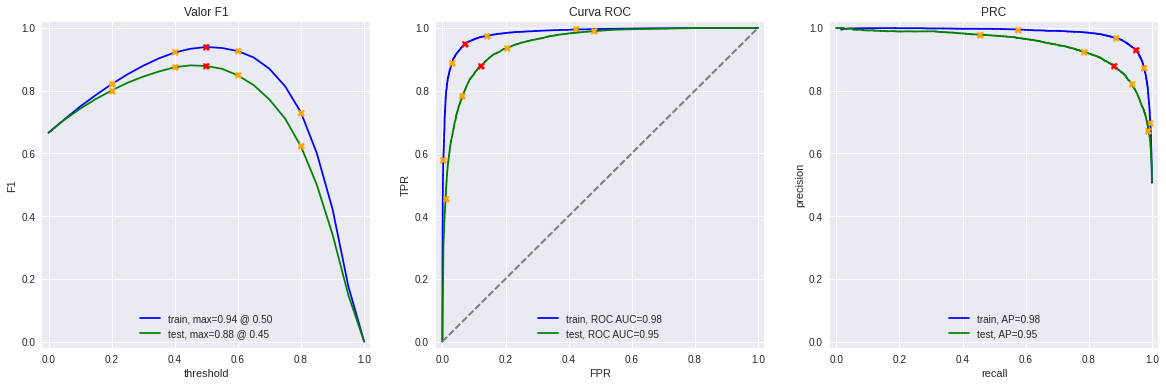

In [62]:
%%time
model_1_evaluation = evaluate_model(model_1, train_tf_idf, train_target, test_tf_idf, test_target)
model_1_evaluation

Empezamos muy bien! Nuestro modelo de Regresión Logística con los datos sin lematizar demuestra unos valores muy buenos... hasta un poco sospechoso un valor tan alto, aunque una diferencia de 0.06 en el F1 entre el conjunto de prueba y el de entrenamiento nos da lugar para creer que no hay **tanto** sobreajuste. 

### <a id='toc1_7_4_'></a>[Modelo 2 - NLTK, TF-IDF y LR](#toc0_)

In [63]:
%%time
model_2 = LogisticRegression()
model_2.fit(nltk_train_tf_idf, train_target)

CPU times: user 2.3 s, sys: 3.97 s, total: 6.27 s
Wall time: 6.2 s


LogisticRegression()

CPU times: user 539 ms, sys: 36.1 ms, total: 575 ms
Wall time: 614 ms


,train,test
Exactitud,0.94,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


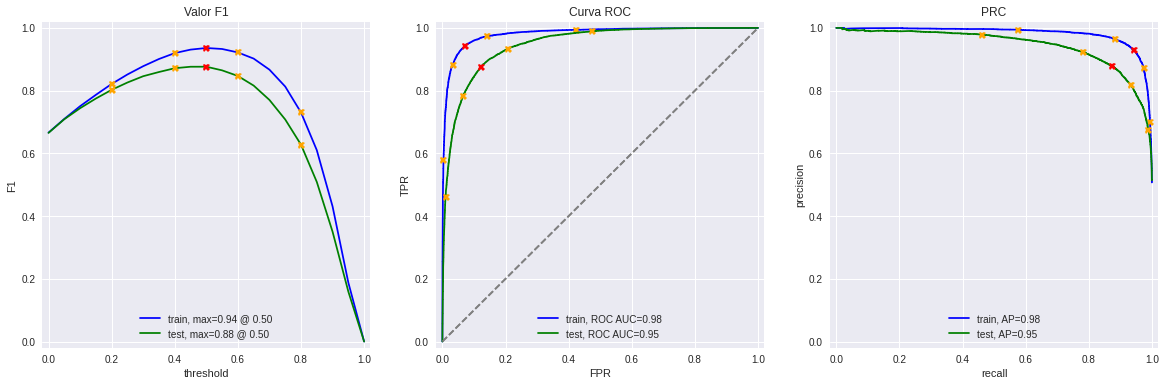

In [64]:
%%time
model_2_evaluation = evaluate_model(model_2, nltk_train_tf_idf, train_target, nltk_test_tf_idf, test_target)
model_2_evaluation

In [65]:
nltk_test_tf_idf != train_tf_idf

True

Un poco raro de similar que son las métricas pero vemos claramente que los conjuntos de entrenamiento no sean iguales. Supongo que no tuvo tanto impacto como el que uno pensaría aplicar la lematización, hasta incluso realentizó un poco el entrenamiento del modelo.

### <a id='toc1_7_5_'></a>[Modelo 3 - spaCy, TF-IDF y LR](#toc0_)

In [66]:
%%time
model_3 = LogisticRegression()
model_3.fit(spacy_train_tf_idf, train_target)

CPU times: user 2.46 s, sys: 3.6 s, total: 6.06 s
Wall time: 6.04 s


LogisticRegression()

CPU times: user 571 ms, sys: 44 µs, total: 571 ms
Wall time: 569 ms


,train,test
Exactitud,0.93,0.87
F1,0.93,0.87
APS,0.98,0.94
ROC AUC,0.98,0.95


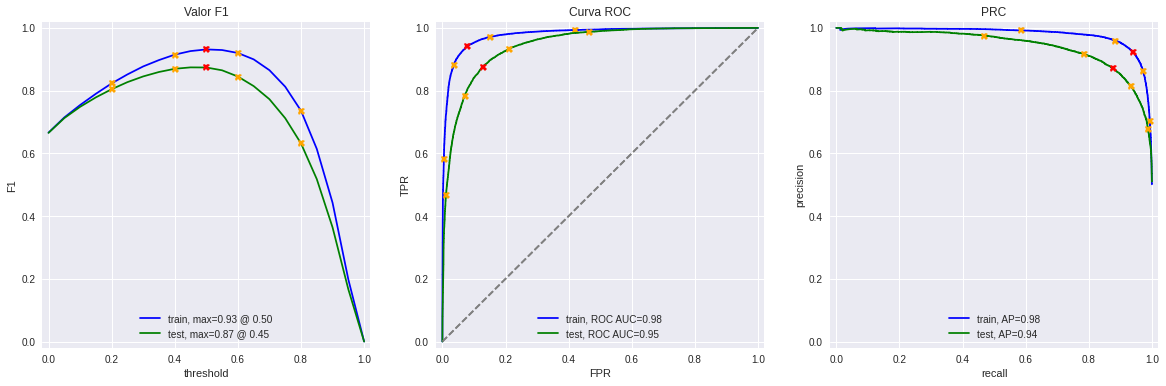

In [67]:
%%time
model_3_evaluation = evaluate_model(model_3, spacy_train_tf_idf, train_target, spacy_test_tf_idf, test_target)
model_3_evaluation

Seguimos observando buenos números, e incluso vemos como el nivel de sobreajuste es igual (0.6) aunque terminamos con valores en ambos datasets menores. La comparación completa la guardaremos para más adelante.

### <a id='toc1_7_6_'></a>[Modelo 4 - TF-IDF y LGBMClassifier](#toc0_)

In [70]:
%%time
model_4 = LGBMClassifier()
model_4.fit(train_tf_idf, train_target)

CPU times: user 58.2 s, sys: 240 ms, total: 58.4 s
Wall time: 58.7 s


LGBMClassifier()

CPU times: user 1.91 s, sys: 60 µs, total: 1.91 s
Wall time: 1.92 s


,train,test
Exactitud,0.91,0.86
F1,0.91,0.86
APS,0.97,0.93
ROC AUC,0.97,0.94


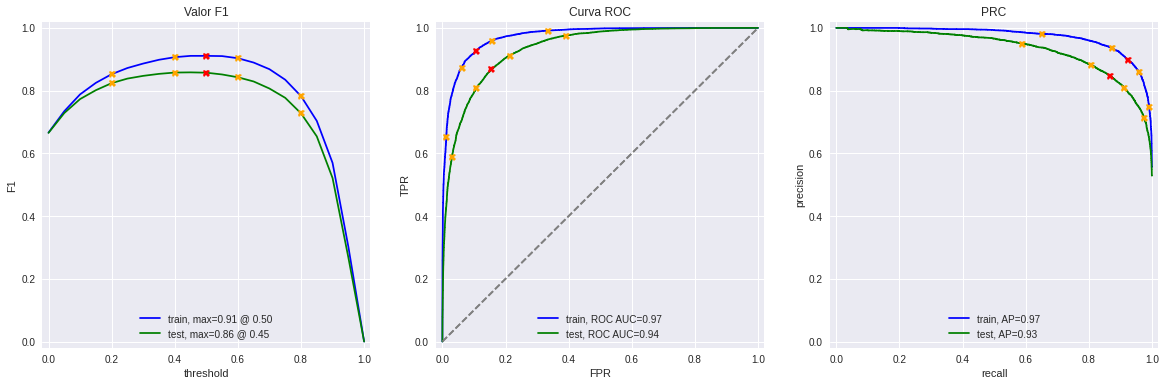

In [71]:
%%time
model_4_evaluation = evaluate_model(model_4, train_tf_idf, train_target, test_tf_idf, test_target)
model_4_evaluation

LightGBM claramente iba a ser diferente de la Regresión Logística. A primera vista uno puede pensar que la complejidad del modelo no se refleja en las métricas ya que son menores que las encontradas en los modelos anteriores, y es verdad. Pero algo que tambien podemos observar es como LightGBM presenta un menor grado de sobreajuste a los datos ya que el puntaje F1 difiere por 0.05 puntos mientras que los otros modelos presentan una diferencia de 0.6

### <a id='toc1_7_7_'></a>[Modelo 5 - NLTK, TF-IDF y LGBMClassifier](#toc0_)

In [72]:
%%time
model_5 = LGBMClassifier()
model_5.fit(nltk_train_tf_idf, train_target)

CPU times: user 53.4 s, sys: 211 ms, total: 53.6 s
Wall time: 53.9 s


LGBMClassifier()

CPU times: user 1.76 s, sys: 3.92 ms, total: 1.76 s
Wall time: 1.77 s


,train,test
Exactitud,0.91,0.85
F1,0.91,0.86
APS,0.97,0.93
ROC AUC,0.97,0.93


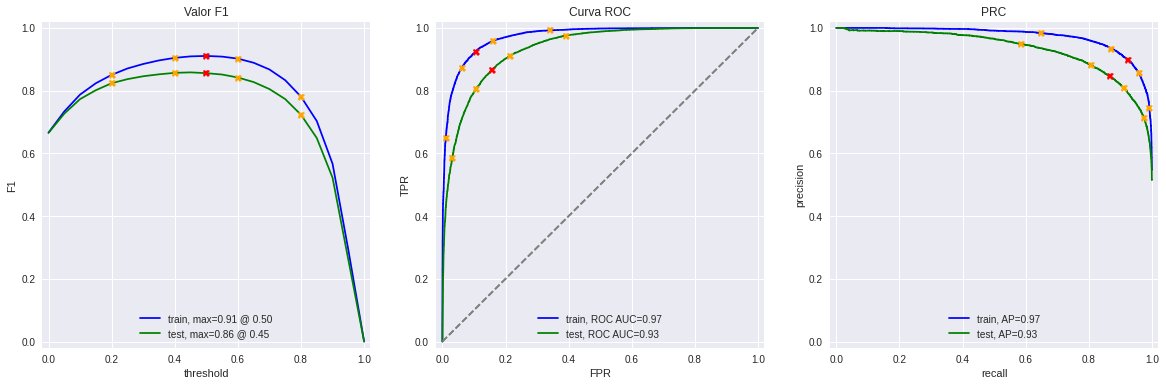

In [73]:
%%time
model_5_evaluation = evaluate_model(model_5, nltk_train_tf_idf, train_target, nltk_test_tf_idf, test_target)
model_5_evaluation

Una vez más vemos que la lematización de los textos no se reflejaron en una mejora notoria del desempeño de los modelos. En el caso de NLTK no es tanto problema ya que la función de lematización no demoró demasiado pero esperemos que spaCy demuestre lo contrario.

### <a id='toc1_7_8_'></a>[Modelo 6 - spaCy, TF-IDF y LGBMClassifier](#toc0_)

In [74]:
%%time
model_6 = LGBMClassifier()
model_6.fit(spacy_train_tf_idf, train_target)

CPU times: user 48.3 s, sys: 242 ms, total: 48.5 s
Wall time: 48.6 s


LGBMClassifier()

CPU times: user 1.69 s, sys: 64 µs, total: 1.69 s
Wall time: 1.71 s


,train,test
Exactitud,0.91,0.85
F1,0.91,0.85
APS,0.97,0.93
ROC AUC,0.97,0.93


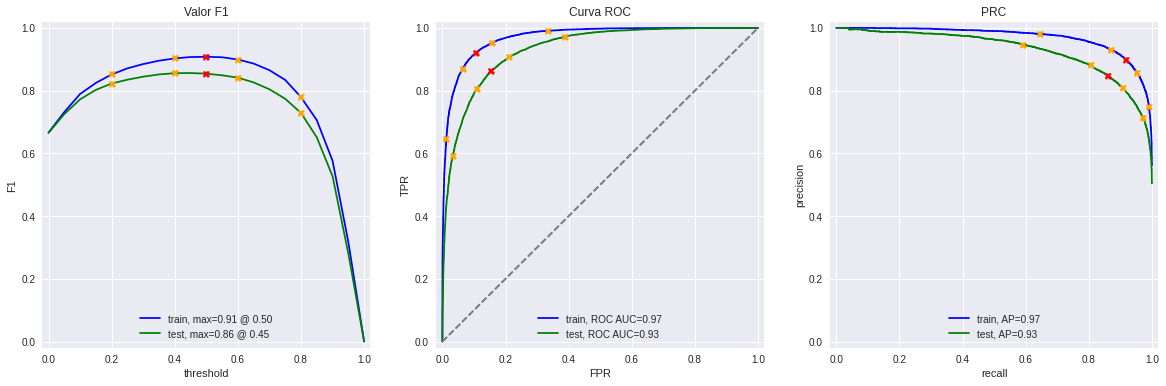

In [75]:
%%time
model_6_evaluation = evaluate_model(model_6, spacy_train_tf_idf, train_target, spacy_test_tf_idf, test_target)
model_6_evaluation

Y... spaCy no sirvió de mucho, o al menos la lematización. Ahora realicemos una comparación de los resultados de todos los df.

In [104]:
# Para eso necesitaremos crear una tabla auxiliar
aux_table = pd.concat([model_1_evaluation.T,model_2_evaluation.T,model_3_evaluation.T,
                       model_4_evaluation.T,model_5_evaluation.T,model_6_evaluation.T])

In [112]:
# Definimos los índices
index_1 = (['LR','LR','LR_NLTK','LR_NLTK','LR_spaCy','LR_spaCy',
            'LightGBM','LightGBM','LightGBM_NLTK','LightGBM_NLTK','LightGBM_spaCy','LightGBM_spaCy'])
index_2 = aux_table.index

# Y creamos un df que nos permita comparar todo
pd.DataFrame(data=aux_table.values, index=[index_1,index_2], columns=test_table.columns)

Exactitud    F1   APS  ROC AUC
LR             train       0.94  0.94  0.98     0.98
               test        0.88  0.88  0.95     0.95
LR_NLTK        train       0.94  0.94  0.98     0.98
               test        0.88  0.88  0.95     0.95
LR_spaCy       train       0.93  0.93  0.98     0.98
               test        0.87  0.87  0.94     0.95
LightGBM       train       0.91  0.91  0.97     0.97
               test        0.86  0.86  0.93     0.94
LightGBM_NLTK  train       0.91  0.91  0.97     0.97
               test        0.85  0.86  0.93     0.93
LightGBM_spaCy train       0.91  0.91  0.97     0.97
               test        0.85  0.85  0.93     0.93

Puede que ma haya costado parte de mi sanidad pero la tabla está completa. Y con ella podemos observar varias cosas...
  
La primera es que la lematización de las reseñas no solo no probó ser beneficiosa para los modelos sino que incluso puede llegar a ser (levemente) perjudicial! 
  
En el caso de la Regresión Logística la lematización de NLTK no modificó el valor de F1 pero spaCy si la disminuyó un poco tanto en el conjunto de entrenamiento como el de prueba (aunque el nivel de sobreajuste no se vió afectado).
  
Mientras tanto a LightGBM sucede algo parecido ya que NLTK no mueve en absoluto el valor F1 pero spaCy redujo el valor con el conjunto de prueba y aumentó levemente el sobreajuste para ubicarlo al igual que los modelos de Regresión Logística!
  
Si observamos el resto de las métricas nos encontramos con comportamientos muy similares pero el hecho de que lematizar los datos no tiene un impacto sobre las predicciones y si tenemos que elegir entre una de las librerías para lematizar nos quedamos con NLTK no solo por su leve superioridad en las métricas sino tambien por la gran diferencia en tiempo para lematizar los textos.

## <a id='toc1_8_'></a>[Mis reseñas](#toc0_)

Ahora vamos a poner a prueba el modelo con unas reseñas propias para ver el desempeño de los modelos en "el mundo real".

In [128]:
my_reviews = pd.DataFrame([
    "I did not simply like it, not my kind of movie.",
    "Well, I was bored and felt asleep in the middle of the movie.",
    "I was really fascinated with the movie",    
    "Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",
    "I didn't expect the reboot to be so good! Writers really cared about the source material",
    "The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",
    "What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",
    "Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama."
], columns=['review'])

my_reviews['review_norm'] = pd.Series(my_reviews['review'].apply(clear_text))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Antes de empezar vamos a destacar que vamos a ser muy simples para determinar si las probabilidades califican como positivas o negativas. Si la probabilidad supera de forma estricta 0.50 la consideramos positiva, de ser 0.50 o menos es negativa.

### <a id='toc1_8_1_'></a>[Modelo 1](#toc0_)

In [122]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn't expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Okay, comenzamos acorde a las métricas ya que observamos 2 reseñas mal catalogadas lo que nos da una efectividad del 75%. Las reseñas en las que falló son la 5ta y la 6ta. Honestamente no entiendo que causó que catalogue tan mal la 5ta ya que no encuentro palabras confusas que puedan dar a entender una negatividad, mientras que la 6ta reseña si aparenta ser más ambigua.

### <a id='toc1_8_2_'></a>[Modelo 2](#toc0_)

In [123]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.08:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.23:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didn't expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.10:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Nos encontramos de vuelta con las mismas reseñas problema aunque ésta vez con una mayor probabilidad de acertar la 5ta y una probabilidad apenas menor en la 6ta.

### <a id='toc1_8_3_'></a>[Modelo 3](#toc0_)

In [129]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_spacy.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.26:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.41:  i didn't expect the reboot to be so good writers really cared about the source material
0.42:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.93:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Ésta instancia de probabilidades es aún más confusa ya que la 3ra reseña que es **claramente** positiva es clasificada, más justo imposible, como negativa (y pasa algo opuesto pero parecido con la 4ta). Por su parte clasifica un poco mejor (pero no suficiente) a la 5ta y 6ta reseña.

### <a id='toc1_8_4_'></a>[Modelo 4](#toc0_)

In [125]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie
0.32:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.44:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didn't expect the reboot to be so good writers really cared about the source material
0.61:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.25:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.70:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


En éste caso vemos como LightGBM es... raro.
  
El modelo logra clasificar casi todas las reseñas de forma correcta excepto una, la 6ta? No, la 1ra! Una reseña claramente negativa es interpretada como positiva y con un pequeño margen de confianza. Ciertamente poner muchos árboles a decidir traen respuestas extrañas.

### <a id='toc1_8_5_'></a>[Modelo 5](#toc0_)

In [130]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_5.predict_proba(tfidf_vectorizer_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  i did not simply like it not my kind of movie
0.35:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.61:  i didn't expect the reboot to be so good writers really cared about the source material
0.58:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.75:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Con éste modelo nos encontramos en que falla en la misma reseña que su hermano sin lematizar, la primera. Cabe destacar que la 4ta reseña está al borde de ser  mal clasificada tambien, pero no lo fue.

### <a id='toc1_8_6_'></a>[Modelo 6](#toc0_)

In [127]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_6.predict_proba(tfidf_vectorizer_spacy.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.25:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.60:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.70:  i didn't expect the reboot to be so good writers really cared about the source material
0.59:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.35:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Acá vemos claramente un ejemplo de por que NLTK superó a spaCy en los resultados. El modelo 6 falló en 2 reseñas (la 1ra, al igual que sus hermanos, y la 4ta) y en donde el modelo 4 y 5 bordeaban el error, éste se posicionó en una posición en la cual es difícil atribuir el crédito por estar cerca.

## <a id='toc1_9_'></a>[Conclusiones](#toc0_)

Al llegar al final del proyecto solo puedo pensar una cosa. Que buen rendimiento que presentaron todos los modelos! Puede que haya estado criticando fuertemente a todos y cada uno de los modelos, pero eso es solo porque eran las conclusiones que se pueden obtener de los datos conseguidos. Si uno observa los resultados nos damos cuenta como solo el peor de los modelos (el modelo 6) no supera con el umbral de 0.85 y no lo supera pero lo alcanza exactamente! De ahí en más llegan hasta 0.88 con los modelos 1 y 2.
  
Otro detalle no menor es que todos los modelos presentaron un grado no despreciable de sobreajuste a los datos. La mayoría se encontraron presentando una diferencia de 0.06 entre el conjunto de entrenamiento y el de prueba, pero los modelos 4 y 5 demostraron una pequeña pero significativa mejoría al portar una diferencia de 0.05. Hay que notar que éstos dos modelos (y el 6) son instancias de LightGBM y que en éste notebook no nos tomamos el trabajo de realizar optimización de hiperparámetros por limitaciones de tiempo. Por lo tanto es completamente posible que con una buena optimización de hiperparámetros es completamente realista creer que una diferencia de 0.02 o incluso 0.01 está dentro del alcance de los modelos.
  
Finalmente voy a cerrar con algo que voy repitiendo múltiples veces pero debido a que tuve que esperar 20 minutos por ellos. La lematización no demostró ser efectiva en absoluto, no se vió ningún cambio rotundamente positivo en ninguna de las métricas que analizamos e incluso, como mencioné previamente, aumentó el nivel de sobreajuste de los datos y bajó el valor F1 del conjunto de pruebas. Si por algún motivo uno tiene la necesidad de utilizar la lematización, la conclusión que me veo obligado a tomar es que se vaya por NLTK y no spaCy. No solo se vió que spaCy afectó negativamente todos los modelos base utilizados (Regresión Logística y LightGBM) sino que hay una métrica muy importante que difiere ampliamente con NLTK: el tiempo de lematización de los textos. Lematizar los textos con spaCy tomó 17 minutos mientras que NLTK hizo lo mismo en 2 minutos (8,5 veces más!), aunque si hablamos de velocidad no puedo darle la ventaja a spaCy de que "sus" modelos si eran entrenados aproximadamente un 2% más rápido.